In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sklearn as sklearn
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
%cd /Users/Allen/Documents/ST4240/kaggle
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train_nf=pd.read_csv("train_newfeatures.csv")
test_nf=pd.read_csv("test_newfeatures.csv")

/Users/Allen/Documents/ST4240/kaggle


In [3]:
#combining dataframes
train = pd.concat([train, train_nf], axis=1)
test = pd.concat([test, test_nf], axis=1)

In [4]:
# remove duplicated ID
train = train.loc[:,~train.columns.duplicated()]
test = test.loc[:,~test.columns.duplicated()]

# Add features
convert Day, Hour, start_cluster, end_cluster to dummy variables

In [5]:
def convertdummy(df,Catcolumn):
    dummies = pd.get_dummies(df[str(Catcolumn)]).rename(columns = lambda x: str(Catcolumn) + str(x))
    df = pd.concat([df, dummies], axis=1)
    df = df.drop([str(Catcolumn)], axis=1)
    return df

In [6]:
train = convertdummy(train, "start_cluster")
train = convertdummy(train, "end_cluster")
train = convertdummy(train, "timerange")
train = convertdummy(train, "Day")

test = convertdummy(test, "start_cluster")
test = convertdummy(test, "end_cluster")
test = convertdummy(test, "timerange")
test = convertdummy(test, "Day")

# Split data

In [7]:
from sklearn.model_selection import train_test_split
traintrain,traintest = train_test_split(train, test_size = 0.3, random_state = 42,shuffle=True ) 

# Modelling 
## benchmark model: 
<br>LR: Use straight distance to predict traj-length and duration 

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def model_eval(model,Xtrain, ytrain, Xtest,ytest):
    model.fit(Xtrain,ytrain)
    pred = model.predict(Xtest)
    print ("Cross Validation score : ")
    print (cross_val_score(model, Xtrain, ytrain, cv=10).mean())
    final = np.exp(pred)
    print ("rmspe : %f" % np.sqrt(np.mean(((final-ytest)/ytest)**2)))

In [13]:
# X:
Xcol=('LOG_STRAIGHT_DIST')
Xtraintrain=traintrain[[Xcol]]
Xtraintest=traintest[[Xcol]]

# y: logduration
logduration_traintrain = traintrain["LOG_DURATION"]
duration_traintest = traintest["DURATION"]

#y: logdistance
logdistance_traintrain = traintrain["LOG_TRAJ_LENGTH"]
distance_traintest = traintest["TRAJ_LENGTH"]

In [12]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
model_eval(LR,Xtraintrain, logduration_traintrain,Xtraintest,duration_traintest)

Cross Validation score : 
0.10721046984831636
rmspe : 0.348944


In [14]:
LR_distance = LinearRegression()
model_eval(LR,Xtraintrain, logdistance_traintrain,Xtraintest,distance_traintest)

Cross Validation score : 
0.5936938421514746
rmspe : 0.302009


## Predict distance 

In [135]:
# X:
Xcol=traintrain.columns[13::]
Xtraintrain=traintrain[Xcol].drop(["hour"], axis=1)
Xtraintest=traintest[Xcol].drop(["hour"], axis=1)

In [136]:
#random forest
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators =100, max_features = "sqrt",bootstrap = True, verbose=0,
                            random_state=42,max_depth = 10)

model_eval(RF,Xtraintrain, logdistance_traintrain,Xtraintest,distance_traintest)

Cross Validation score : 
0.609774924100168
rmspe : 0.423547


Feature ranking:
1. feature 0 (0.535019) 
2. feature 43 (0.061465) 
3. feature 56 (0.050650) 
4. feature 42 (0.041163) 
5. feature 53 (0.034386) 
6. feature 70 (0.023133) 
7. feature 55 (0.022874) 
8. feature 32 (0.022752) 
9. feature 54 (0.016596) 
10. feature 57 (0.016491) 
11. feature 39 (0.015307) 
12. feature 63 (0.010785) 
13. feature 66 (0.009992) 
14. feature 76 (0.009619) 
15. feature 51 (0.009064) 
16. feature 50 (0.008212) 
17. feature 72 (0.007920) 
18. feature 41 (0.006650) 
19. feature 1 (0.005747) 
20. feature 45 (0.005745) 
21. feature 74 (0.005603) 
22. feature 46 (0.004768) 
23. feature 40 (0.004719) 
24. feature 58 (0.004398) 
25. feature 33 (0.003952) 
26. feature 65 (0.003850) 
27. feature 20 (0.003611) 
28. feature 17 (0.002851) 
29. feature 78 (0.002791) 
30. feature 44 (0.002768) 
31. feature 67 (0.002567) 
32. feature 16 (0.002436) 
33. feature 80 (0.002416) 
34. feature 48 (0.002181) 
35. feature 73 (0.001968) 
36. feature 31 (0.001958) 
37. feature 13 (0.0019

(-1, 112)

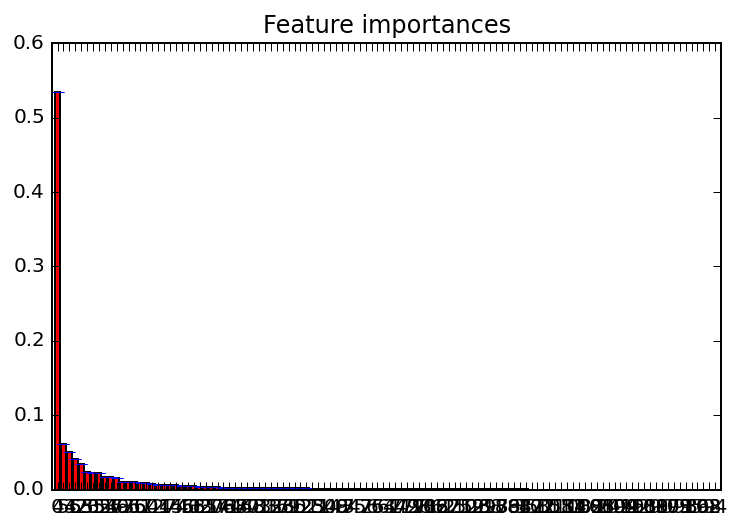

In [102]:
#feature importance 
importances = RF.feature_importances_
std = np.std([RF.feature_importances_ for tree in RF.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xtraintrain.shape[1]):
    print("%d. feature %d (%f) " % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(Xtraintrain.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(Xtraintrain.shape[1]), indices)
plt.xlim([-1, Xtraintrain.shape[1]])
#plt.show()

In [298]:
#gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators=100, max_features = "sqrt",learning_rate=0.1,
       max_depth=1, random_state=42, loss='ls',subsample = 0.8)

model_eval(GBR,Xtraintrain, logdistance_traintrain,Xtraintest,logdistance_traintest)

Cross Validation score : 
0.522295110228
rmspe : 0.070294


In [299]:
GBR.feature_importances_

array([ 0.14,  0.01,  0.  ,  0.01,  0.03,  0.01,  0.01,  0.  ,  0.01,
        0.02,  0.  ,  0.  ,  0.01,  0.03,  0.01,  0.  ,  0.  ,  0.02,
        0.  ,  0.  ,  0.  ,  0.06,  0.05,  0.09,  0.05,  0.05,  0.03,
        0.  ,  0.09,  0.03,  0.02,  0.  ,  0.01,  0.02,  0.  ,  0.04,
        0.01,  0.02,  0.  ,  0.08,  0.03,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

add the predicted logdistance to the test data

In [137]:
pred_logdistance_traintest = RF.predict(Xtraintest)
traintest = traintest.assign(pred_logdistance = pred_logdistance_traintest)

## predict duration
<br>'LOG_STRAIGHT_DIST',
'Day',
 'hour',
 'start_cluster',
 'end_cluster'

In [122]:
Xcol=traintrain.columns[13::]
Xtraintrain=traintrain[Xcol].drop(["hour"], axis=1)
Xtraintest=traintest[Xcol].drop(["hour"], axis=1)

In [123]:
RF_d = RandomForestRegressor(n_estimators =100, max_features = "sqrt",bootstrap = True, verbose=0,
                            random_state=42,max_depth = 10)

model_eval(RF_d,Xtraintrain, logduration_traintrain,Xtraintest,duration_traintest)

Cross Validation score : 
0.2110678565352913
rmspe : 0.332495


Feature ranking:


(-1, 60)

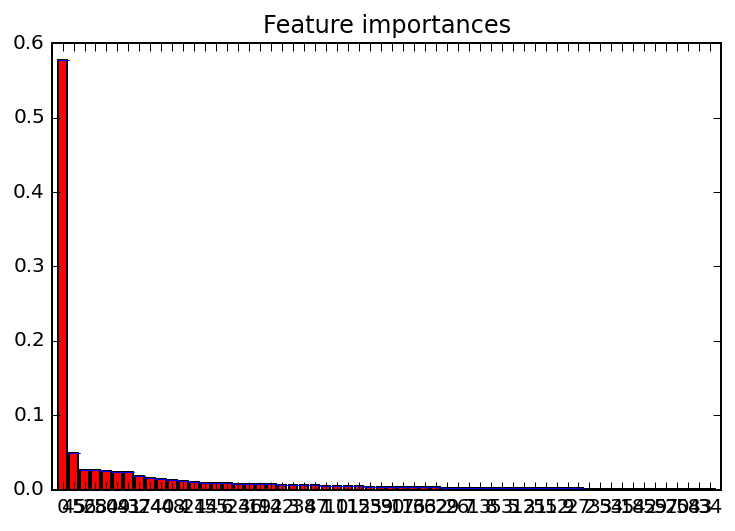

In [312]:
#feature importance 
importances = RF_d.feature_importances_
std = np.std([RF_d.feature_importances_ for tree in RF_d.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#for f in range(Xtraintrain.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(Xtraintrain.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(Xtraintrain.shape[1]), indices)
plt.xlim([-1, Xtraintrain.shape[1]])
#plt.show()

In [313]:
GBR_du = GradientBoostingRegressor(n_estimators=100, max_features = "sqrt",learning_rate=0.1,
       max_depth=1, random_state=42, loss='ls',subsample = 0.8)

model_eval(GBR_du,Xtraintrain, logduration_traintrain,Xtraintest,logduration_traintest)

Cross Validation score : 
0.172066409272
rmspe : 0.061396


now use 
<br>'LOG_TRAJ_LENGTH',
'Day',
 'hour',
 'start_cluster',
 'end_cluster'

In [140]:
Xcol=traintrain.columns[12::]
Xtraintrain=traintrain[Xcol].drop(["hour","LOG_STRAIGHT_DIST","start_density","end_density"], axis=1)
Xcol=traintest.columns[17::]
Xtraintest=traintest[Xcol]
#use our predicted distance as log_traj_length
Xtraintest.rename(columns={'pred_logdistance': "LOG_TRAJ_LENGTH"}, inplace=True)

In [143]:
#duration using approximated distance 
RF_d2 = RandomForestRegressor(n_estimators =100, max_features = "sqrt",bootstrap = True, verbose=0,
                            random_state=42,max_depth = 10)

model_eval(RF_d2,Xtraintrain, logduration_traintrain,Xtraintest,duration_traintest)

Cross Validation score : 
0.33707346677984396
rmspe : 0.334975


## xgboost
   gridsearch

In [18]:
Xcol = train.columns[13:]
Xfinal=train[Xcol].drop(["hour"], axis=1)
Xtest=test[Xcol].drop(["hour"], axis=1)

#y: logdistance
y_logdistance = train["LOG_TRAJ_LENGTH"]

# y: logduration
y_logduration = train["LOG_DURATION"]

In [ ]:
# for distance:

In [21]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
#for the first parameter, we try to look for the best n_estimators under learning_rate = 0.1

param_test1 = {'n_estimators':range(100,300,50)}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, 
                                     objective='reg:linear', booster='gbtree',  
                                     gamma=0, min_child_weight=1, subsample=0.8, 
                                     colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, 
                                     scale_pos_weight=1, random_state=42, seed=42), 
                       param_grid = param_test1, scoring='neg_mean_squared_error',iid=False,cv=5)
gsearch1.fit(Xfinal,y_logdistance)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.08211, std: 0.00065, params: {'n_estimators': 100},
  mean: -0.08051, std: 0.00060, params: {'n_estimators': 150},
  mean: -0.07957, std: 0.00057, params: {'n_estimators': 200},
  mean: -0.07897, std: 0.00059, params: {'n_estimators': 250}],
 {'n_estimators': 250},
 -0.07896836466622012)

In [ ]:
#We then use the best estimated n_estimators(250) and search for the best max_depth
param_test2 = {
 'max_depth':range(10,15,2),
 'min_child_weight':range(1,6,2)
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators = 200, learning_rate=0.1, 
                                     objective='reg:linear', booster='gbtree',  
                                     gamma=0, subsample=0.8, 
                                     colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, 
                                     scale_pos_weight=1, random_state=42, seed=42), 
                       param_grid = param_test2, scoring='neg_mean_squared_error',iid=False,cv=5)
gsearch2.fit(Xfinal,y_logdistance)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [26]:
#gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,4)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators = 250, max_depth=9，min_child_weight=1,
                                     learning_rate=0.1, objective='reg:linear', booster='gbtree',  
                                     subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, 
                                     scale_pos_weight=1, random_state=42, seed=42), 
                       param_grid = param_test3, scoring='neg_mean_squared_error',iid=False,cv=5)
gsearch3.fit(Xfinal,y_logdistance)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

SyntaxError: invalid character in identifier (<ipython-input-26-3a56ec45bed8>, line 5)

In [ ]:
#subsample, colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators = 250, max_depth=6，min_child_weight=1,
                                     gamma=0, learning_rate=0.1, objective='reg:linear', booster='gbtree',  
                                     reg_alpha=0, reg_lambda=1, 
                                     scale_pos_weight=1, random_state=42, seed=42), 
                       param_grid = param_test4, scoring='neg_mean_squared_error',iid=False,cv=5)
gsearch4.fit(Xfinal,y_logdistance)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators = 250, max_depth=6，min_child_weight=1,
                                     gamma=0, subsample=0.8, colsample_bytree=0.8,
                                    learning_rate=0.1, objective='reg:linear', booster='gbtree',  
                                    reg_lambda=1, 
                                    scale_pos_weight=1, random_state=42, seed=42), 
                       param_grid = param_test5, scoring='neg_mean_squared_error',iid=False,cv=5)
gsearch5.fit(Xfinal,y_logdistance)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
# for duration

In [ ]:
param_test6 = {'n_estimators':range(100,300,50)}
gsearch6 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, 
                                     objective='reg:linear', booster='gbtree',  
                                     gamma=0, min_child_weight=1, subsample=0.8, 
                                     colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, 
                                     scale_pos_weight=1, random_state=42, seed=42), 
                       param_grid = param_test6, scoring='neg_mean_squared_error',iid=False,cv=5)
gsearch6.fit(Xfinal,y_logduration)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test7 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch7 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators = 250, learning_rate=0.1, 
                                     objective='reg:linear', booster='gbtree',  
                                     gamma=0, subsample=0.8, 
                                     colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, 
                                     scale_pos_weight=1, random_state=42, seed=42), 
                       param_grid = param_test7, scoring='neg_mean_squared_error',iid=False,cv=5)
gsearch7.fit(Xfinal,y_logduration)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
#gamma
param_test8 = {
 'gamma':[i/10.0 for i in range(0,4)]
}
gsearch8 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators = 250, max_depth=6，min_child_weight=1,
                                     learning_rate=0.1, objective='reg:linear', booster='gbtree',  
                                     subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, 
                                     scale_pos_weight=1, random_state=42, seed=42), 
                       param_grid = param_test8, scoring='neg_mean_squared_error',iid=False,cv=5)
gsearch8.fit(Xfinal,y_logduration)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

In [ ]:
#subsample, colsample_bytree
param_test9 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch9 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators = 250, max_depth=6，min_child_weight=1,
                                     gamma=0, learning_rate=0.1, objective='reg:linear', booster='gbtree',  
                                     reg_alpha=0, reg_lambda=1, 
                                     scale_pos_weight=1, random_state=42, seed=42), 
                       param_grid = param_test9, scoring='neg_mean_squared_error',iid=False,cv=5)
gsearch9.fit(Xfinal,y_logdistance)
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

In [ ]:
param_test10 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch10 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators = 250, max_depth=6，min_child_weight=1,
                                     gamma=0, subsample=0.8, colsample_bytree=0.8,
                                    learning_rate=0.1, objective='reg:linear', booster='gbtree',  
                                    reg_lambda=1, 
                                    scale_pos_weight=1, random_state=42, seed=42), 
                       param_grid = param_test10, scoring='neg_mean_squared_error',iid=False,cv=5)
gsearch10.fit(Xfinal,y_logdistance)
gsearch10.grid_scores_, gsearch10.best_params_, gsearch10.best_score_

# final model

In [16]:
final_dis = xgb.XGBRegressor(n_estimators = 250, max_depth=6，min_child_weight=1,
                                     gamma=0, subsample=0.8, colsample_bytree=0.8,
                                    learning_rate=0.1, objective='reg:linear', booster='gbtree',  
                                    reg_lambda=1, #lambda
                                    scale_pos_weight=1, random_state=42, seed=42)
final_du = xgb.XGBRegressor(n_estimators = 250, max_depth=6，min_child_weight=1,
                                     gamma=0, subsample=0.8, colsample_bytree=0.8,
                                    learning_rate=0.1, objective='reg:linear', booster='gbtree',  
                                    reg_lambda=1, #lambda
                                    scale_pos_weight=1, random_state=42, seed=42)

In [34]:
# predict distance
final_dis.fit(Xfinal, y_logdistance)
pred_distance = np.exp(final_dis.predict(Xtest))

In [35]:
# predict duration
final_du.fit(Xfinal, y_logduration)
pred_duration = np.exp(final_du.predict(Xtest))

In [36]:
pred_price = pred_duration + pred_distance
keys = test ["ID"]
dictionary = dict(zip(keys, list(pred_price)))

In [37]:
import csv
with open('my_file.csv', 'w') as f:
    [f.write('{0},{1}\n'.format(key, value)) for key, value in dictionary.items()]
    
# note: need to manually add the ID and PRICE heading

In [38]:
pred_price

array([297.52747, 290.4405 , 480.3279 , ..., 497.80887, 268.54373,
       367.07062], dtype=float32)